<a href="https://colab.research.google.com/github/PatilVaishnav131/disease-prediction-ai/blob/main/skin_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ismailpromus_skin_diseases_image_dataset_path = kagglehub.dataset_download('ismailpromus/skin-diseases-image-dataset')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


2025-08-09 14:54:28.816447: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754751269.181251      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754751269.278829      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import os
import pandas as pd

# Path to the dataset
parent_folder_path = "/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES"

# Lists to store image paths and labels
image_paths = []
class_labels = []

# Dictionary to map integer class labels to class names
class_label_map = {}

# Loop through each subfolder (each disease class)
for subfolder_name in os.listdir(parent_folder_path):
    # e.g. '1.Melanoma', '2.Atopic', ...
    parts = subfolder_name.split(".")
    class_label = int(parts[0]) - 1  # ensure class_label starts at 0
    # Extract class name from folder (handles potential whitespace)
    class_name = parts[1].strip()
    class_label_map[class_label] = class_name

    subfolder_path = os.path.join(parent_folder_path, subfolder_name)
    for image_name in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_name)
        image_paths.append(image_path)
        class_labels.append(class_label)

# Create DataFrame from paths and labels
df = pd.DataFrame({
    "image_path": image_paths,
    "class_label": class_labels
})

# Number of distinct classes, computed directly from labels
num_classes = df["class_label"].nunique()

print("Number of classes:", num_classes)
print("Class label map:", class_label_map)
print(df.head())


Number of classes: 10
Class label map: {0: 'Eczema 1677', 9: 'Warts Molluscum and other Viral Infections - 2103', 3: 'Basal Cell Carcinoma (BCC) 3323', 6: 'Psoriasis pictures Lichen Planus and related diseases - 2k', 4: 'Melanocytic Nevi (NV) - 7970', 8: 'Tinea Ringworm Candidiasis and other Fungal Infections - 1', 2: 'Atopic Dermatitis - 1', 5: 'Benign Keratosis-like Lesions (BKL) 2624', 7: 'Seborrheic Keratoses and other Benign Tumors - 1', 1: 'Melanoma 15'}
                                          image_path  class_label
0  /kaggle/input/skin-diseases-image-dataset/IMG_...            0
1  /kaggle/input/skin-diseases-image-dataset/IMG_...            0
2  /kaggle/input/skin-diseases-image-dataset/IMG_...            0
3  /kaggle/input/skin-diseases-image-dataset/IMG_...            0
4  /kaggle/input/skin-diseases-image-dataset/IMG_...            0


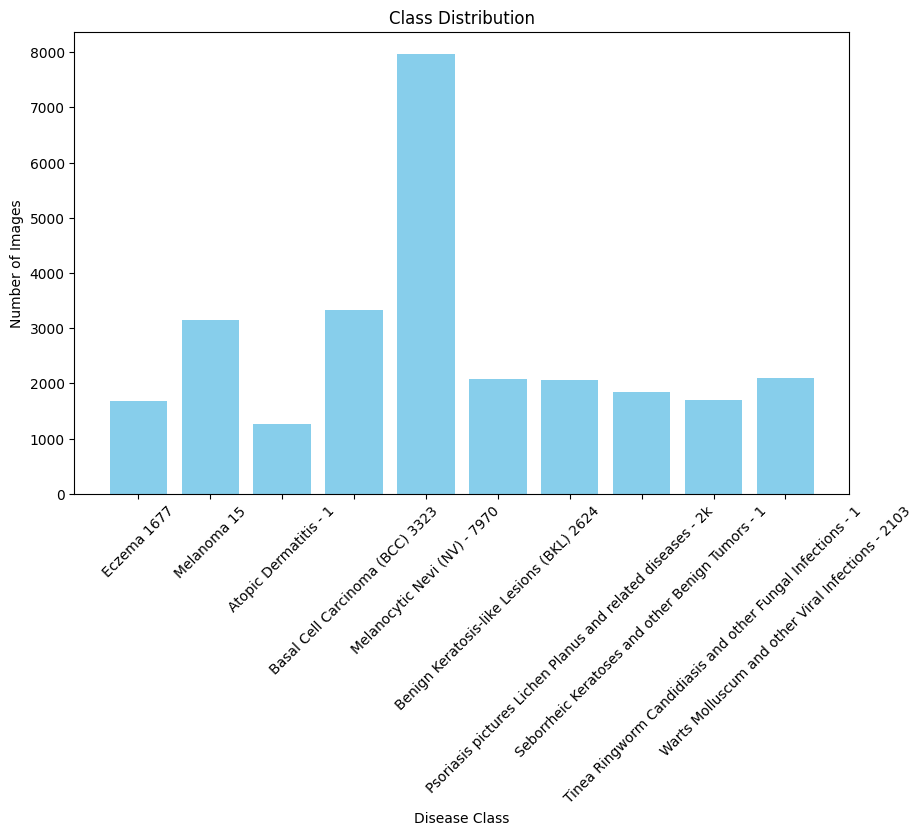

In [ ]:
import matplotlib.pyplot as plt

# Count samples per class
class_counts = df['class_label'].value_counts().sort_index()

# Map class labels to names
class_names = [class_label_map[label] for label in class_counts.index]

plt.figure(figsize=(10,6))
plt.bar(class_names, class_counts.values, color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Disease Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()


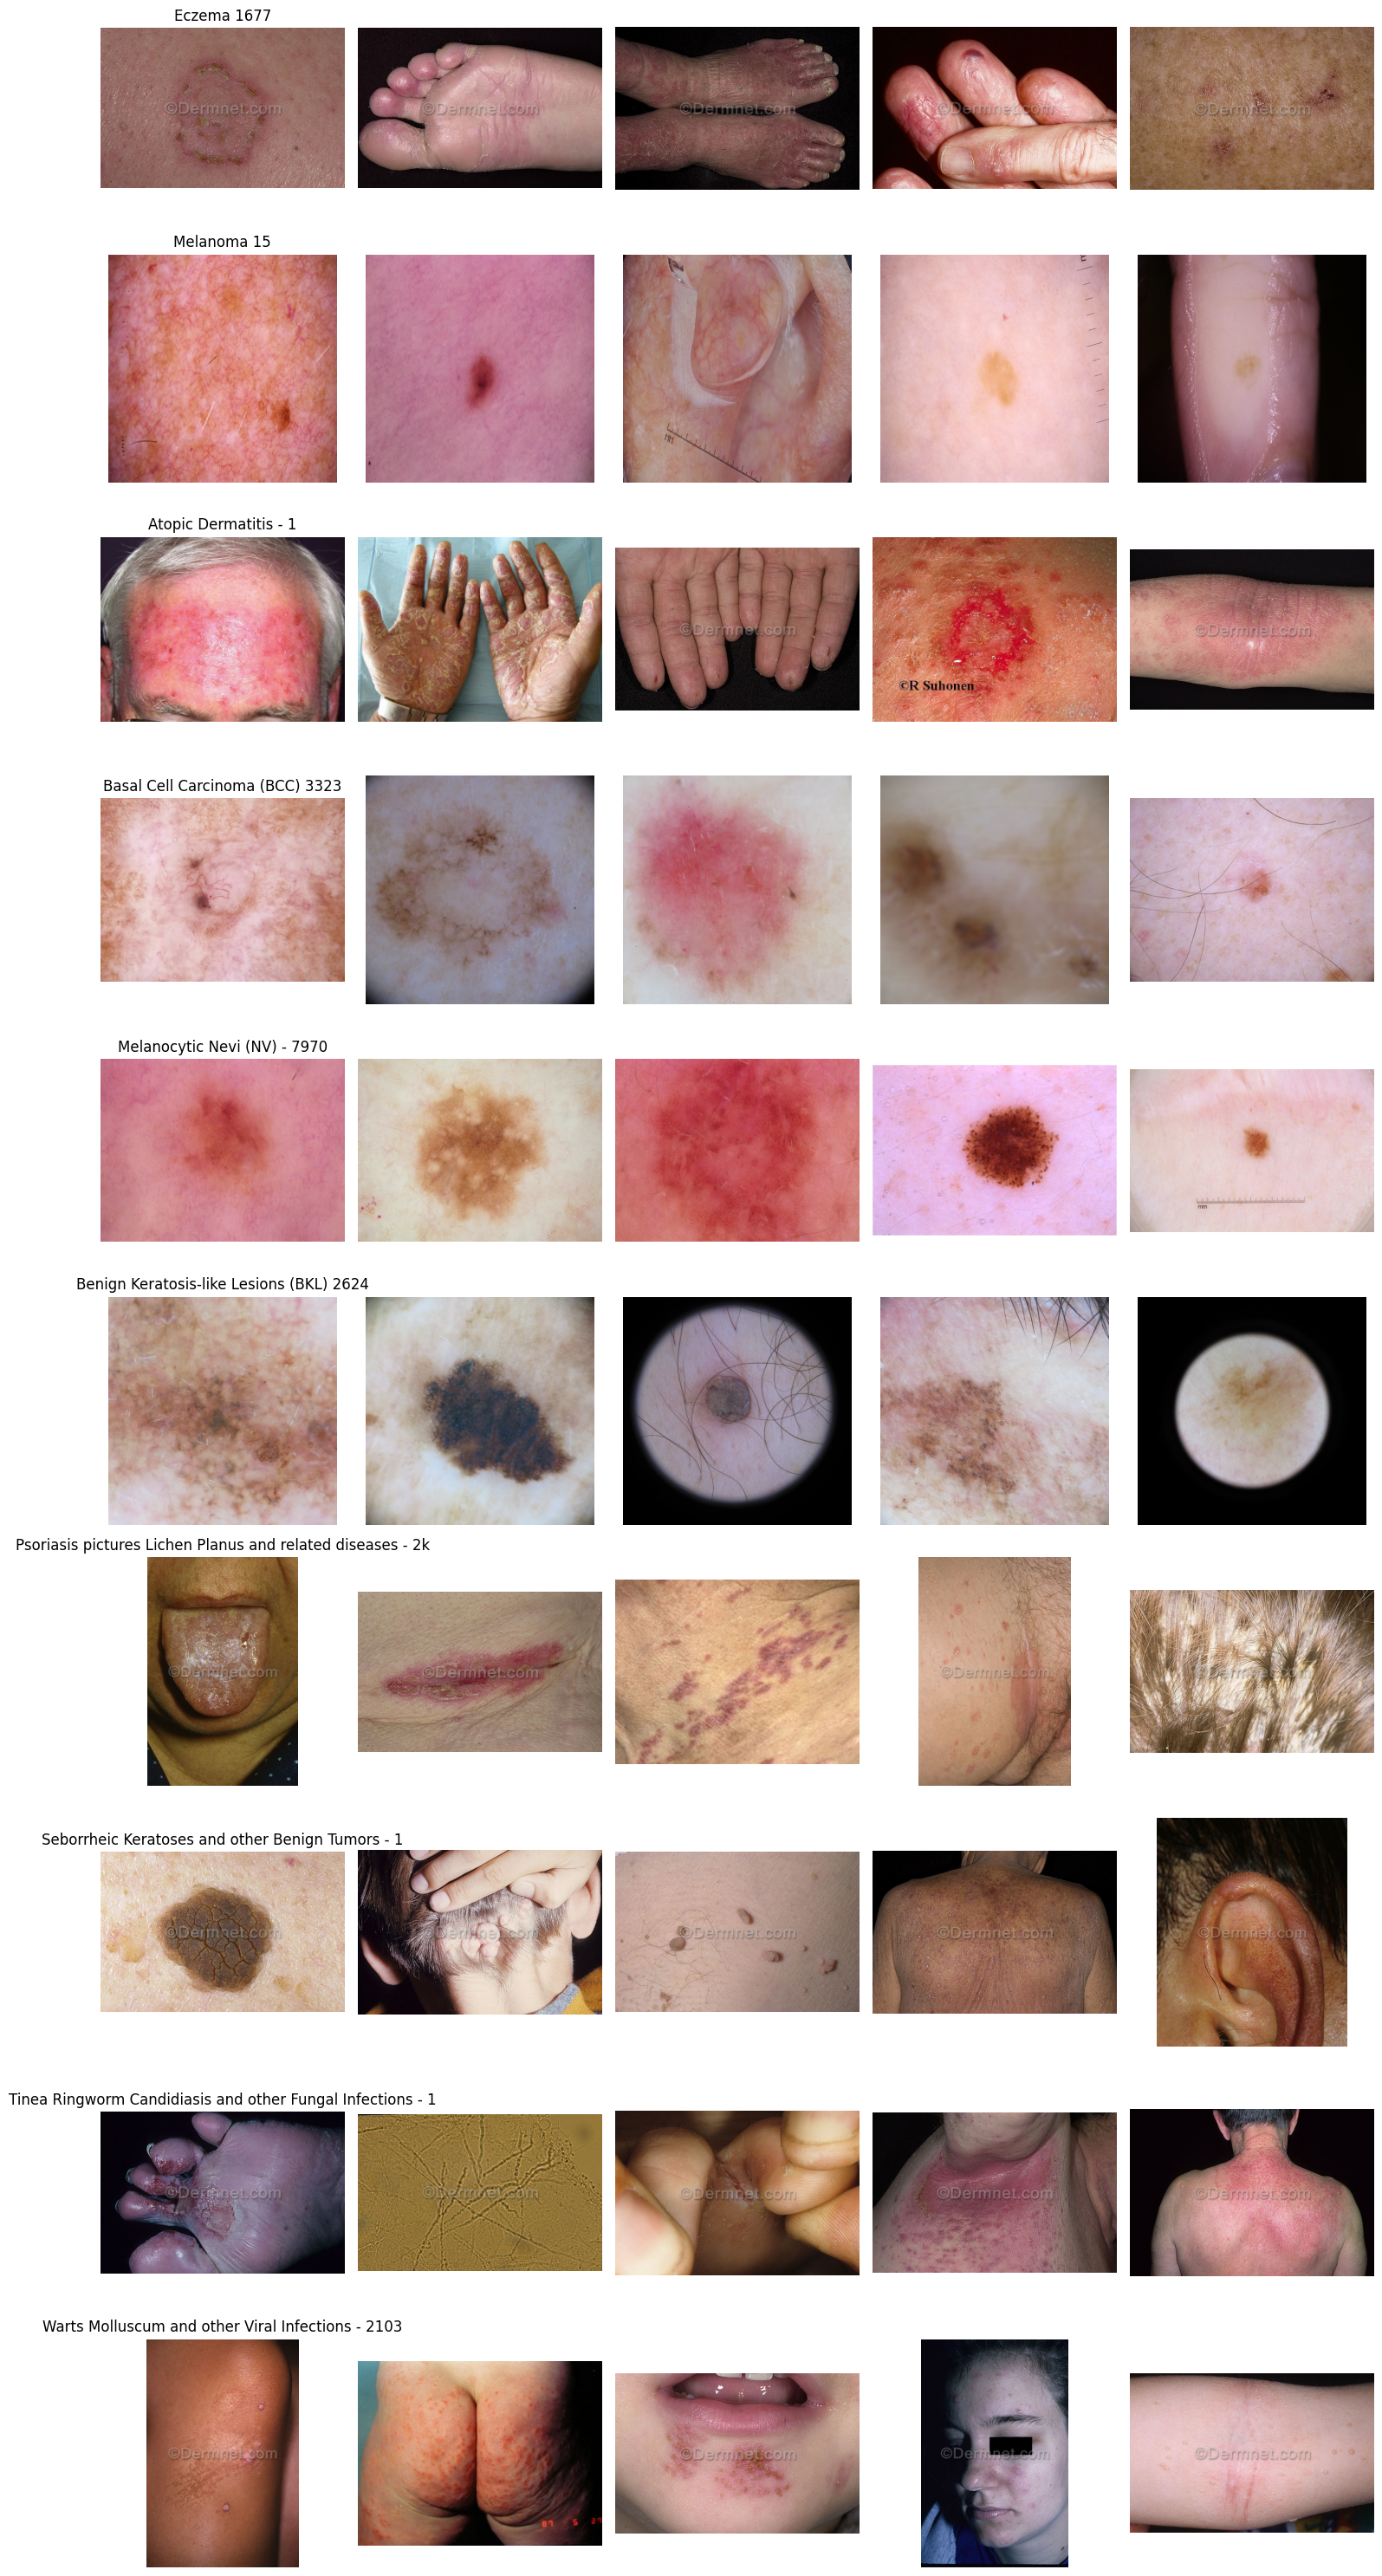

In [ ]:
import random
from PIL import Image

num_classes = len(class_label_map)
fig, axes = plt.subplots(num_classes, 5, figsize=(15, 3*num_classes))

for i, class_label in enumerate(sorted(class_label_map.keys())):
    img_paths = df[df['class_label']==class_label]['image_path'].sample(5, random_state=42)
    for j, img_path in enumerate(img_paths):
        img = Image.open(img_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(class_label_map[class_label])
plt.tight_layout()
plt.show()


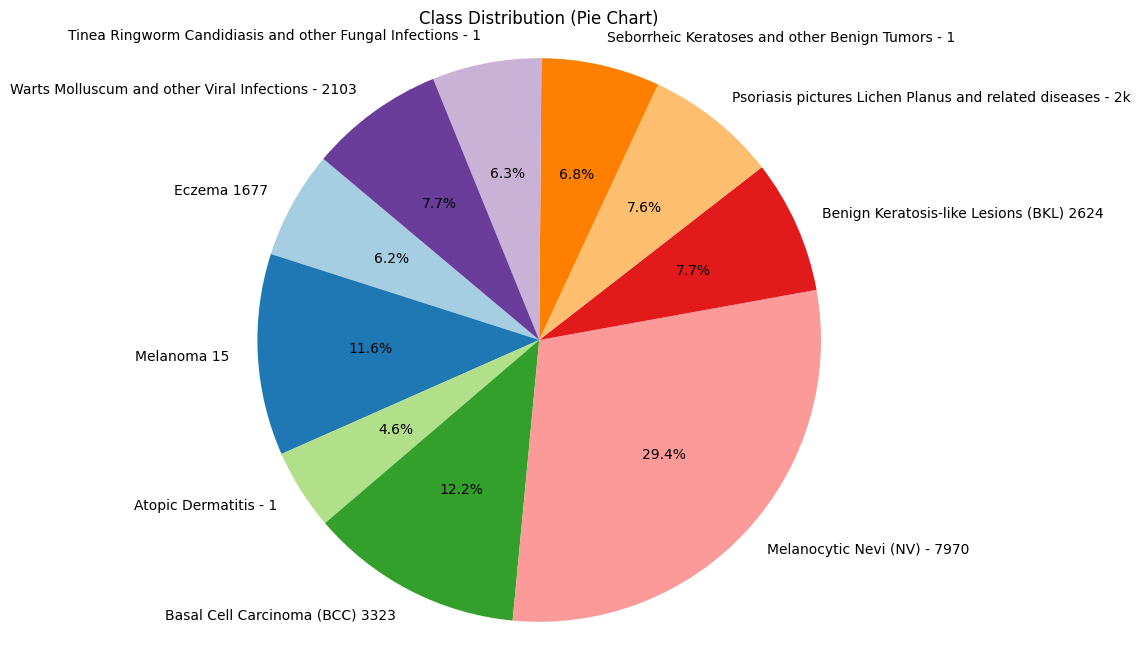

In [ ]:
plt.figure(figsize=(8,8))
plt.pie(class_counts.values, labels=class_names, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Class Distribution (Pie Chart)')
plt.axis('equal')
plt.show()


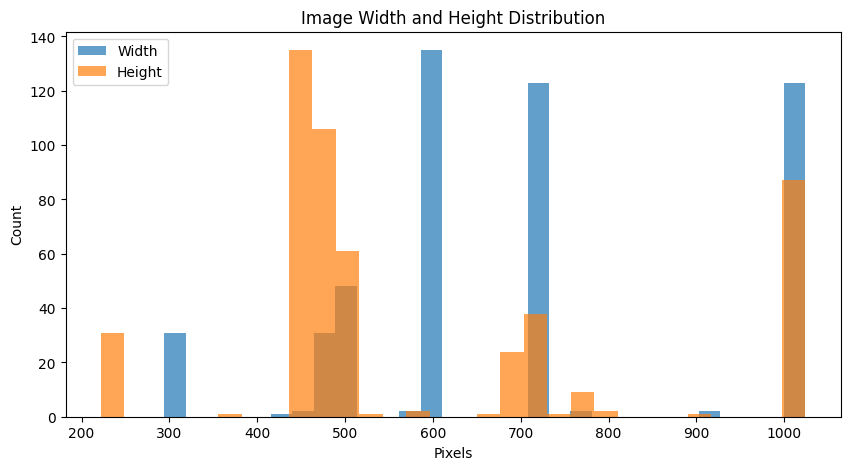

In [ ]:
# Image size distribution
sizes = []
for img_path in df['image_path'].sample(500, random_state=42):  # Sample for speed
    img = Image.open(img_path)
    sizes.append(img.size)

widths, heights = zip(*sizes)
plt.figure(figsize=(10,5))
plt.hist(widths, bins=30, alpha=0.7, label='Width')
plt.hist(heights, bins=30, alpha=0.7, label='Height')
plt.title('Image Width and Height Distribution')
plt.xlabel('Pixels')
plt.ylabel('Count')
plt.legend()
plt.show()


In [ ]:
# Data splitting
train_df, temp_df = train_test_split(
    df, test_size=0.3, stratify=df['class_label'], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['class_label'], random_state=42
)
print("Train:", len(train_df), "Valid:", len(val_df), "Test:", len(test_df))

Train: 19007 Valid: 4073 Test: 4073


In [ ]:
# Map integers to string disease names
df['class_name'] = df['class_label'].map(class_label_map)

# After you split the dataframe:
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['class_label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class_label'], random_state=42)


In [ ]:
# Map integer class labels to string class names
df["class_name"] = df["class_label"].map(class_label_map)

# Use 'class_name' for splitting and generator setup
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df["class_label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["class_label"], random_state=42)

# When creating train/validation/test generators:
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col="image_path",
    y_col="class_name",  # <--- must be string labels!
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col="image_path",
    y_col="class_name",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col="image_path",
    y_col="class_name",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 19007 validated image filenames belonging to 10 classes.
Found 4073 validated image filenames belonging to 10 classes.
Found 4073 validated image filenames belonging to 10 classes.


In [ ]:
base_model = DenseNet121(
    weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Freeze base
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


I0000 00:00:1754751451.076532      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754751451.077358      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,047,754 (26.89 MB)

 Trainable params: 10,250 (40.04 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6),
    ModelCheckpoint('/kaggle/working/best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]


Training model


In [ ]:
 EPOCHS = 15
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1754751499.668853     102 service.cc:148] XLA service 0x7859a4020bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754751499.670428     102 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754751499.670456     102 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754751502.736813     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/594 ━━━━━━━━━━━━━━━━━━━━ 5:57:24 36s/step - accuracy: 0.1875 - loss: 2.5894

I0000 00:00:1754751515.595187     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.3925 - loss: 1.7843
Epoch 1: val_loss improved from inf to 1.05960, saving model to /kaggle/working/best_model.h5
594/594 ━━━━━━━━━━━━━━━━━━━━ 538s 846ms/step - accuracy: 0.3926 - loss: 1.7838 - val_accuracy: 0.6094 - val_loss: 1.0596 - learning_rate: 0.0010
Epoch 2/15
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.5373 - loss: 1.2369
Epoch 2: val_loss improved from 1.05960 to 1.02257, saving model to /kaggle/working/best_model.h5
594/594 ━━━━━━━━━━━━━━━━━━━━ 350s 590ms/step - accuracy: 0.5373 - loss: 1.2369 - val_accuracy: 0.6084 - val_loss: 1.0226 - learning_rate: 0.0010
Epoch 3/15
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.5577 - loss: 1.1701
Epoch 3: val_loss improved from 1.02257 to 0.99444, saving model to /kaggle/working/best_model.h5
594/594 ━━━━━━━━━━━━━━━━━━━━ 344s 579ms/step - accuracy: 0.5577 - loss: 1.1701 - val_accuracy: 0.6307 - val_loss: 0.9944 - learning_rate: 0.0010
Epoch 4/15
594/594 ━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 60s 469ms/step - accuracy: 0.6689 - loss: 0.9233
Test Loss: 0.9235, Test Acc: 0.6614
128/128 ━━━━━━━━━━━━━━━━━━━━ 52s 306ms/step
                                                            precision    recall  f1-score   support

                                               Eczema 1677       0.47      0.20      0.28       188
                                               Melanoma 15       0.77      0.82      0.79       499
                                     Atopic Dermatitis - 1       0.65      0.37      0.47       312
                           Basal Cell Carcinoma (BCC) 3323       0.45      0.51      0.48       252
                              Melanocytic Nevi (NV) - 7970       0.76      0.94      0.84      1196
                  Benign Keratosis-like Lesions (BKL) 2624       0.91      0.62      0.74       471
Psoriasis pictures Lichen Planus and related diseases - 2k       0.47      0.35      0.40       308
          Seborrheic Keratoses and other 

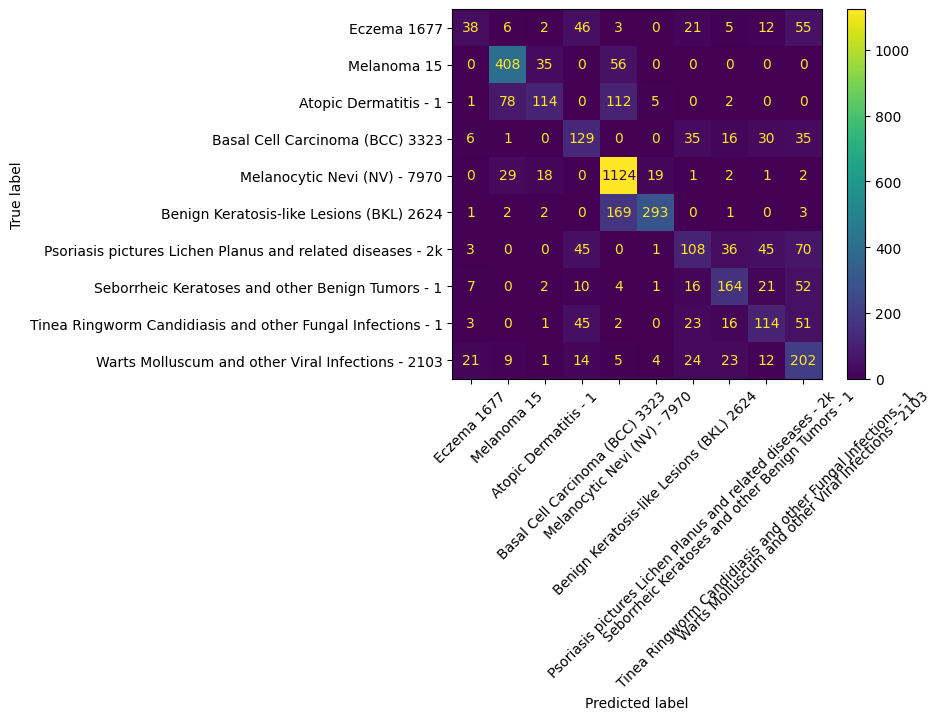

In [ ]:
# Use the best model
model.load_weights('/kaggle/working/best_model.h5')

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

# Classification Report
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_true, y_pred, target_names=[str(class_label_map[i]) for i in range(num_classes)]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=[str(class_label_map[i]) for i in range(num_classes)])
disp.plot(xticks_rotation=45)
plt.show()


In [ ]:
# Unfreeze last DenseNet blocks for fine-tuning
for layer in base_model.layers[-50:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

fine_tune_epochs = 5
ft_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=fine_tune_epochs,
    callbacks=callbacks
)


Epoch 1/5
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.5102 - loss: 1.6259
Epoch 1: val_loss did not improve from 0.93699
594/594 ━━━━━━━━━━━━━━━━━━━━ 442s 669ms/step - accuracy: 0.5102 - loss: 1.6257 - val_accuracy: 0.6482 - val_loss: 1.0169 - learning_rate: 1.0000e-05
Epoch 2/5
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.5536 - loss: 1.3924
Epoch 2: val_loss did not improve from 0.93699
594/594 ━━━━━━━━━━━━━━━━━━━━ 347s 583ms/step - accuracy: 0.5536 - loss: 1.3924 - val_accuracy: 0.6531 - val_loss: 0.9796 - learning_rate: 1.0000e-05
Epoch 3/5
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.5690 - loss: 1.3105
Epoch 3: val_loss did not improve from 0.93699
594/594 ━━━━━━━━━━━━━━━━━━━━ 347s 584ms/step - accuracy: 0.5690 - loss: 1.3105 - val_accuracy: 0.6582 - val_loss: 0.9537 - learning_rate: 1.0000e-05
Epoch 4/5
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.5836 - loss: 1.2482
Epoch 4: val_loss did not improve from 0.93699
594/594 ━━━━━━━━━

**Applying Oversampling to handle class imabalance **

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class BalancedSequence(tf.keras.utils.Sequence):
    def __init__(self, df, class_label_map, batch_size, img_size, augmentation_fn=None):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.augmentation_fn = augmentation_fn

        self.labels = df['class_label'].values
        self.class_indices = {}
        for cls in np.unique(self.labels):
            self.class_indices[cls] = np.where(self.labels == cls)[0]

        # Calculate sampling probabilities inversely proportional to class frequency
        class_counts = {cls: len(idxs) for cls, idxs in self.class_indices.items()}
        total = sum(class_counts.values())
        self.class_probs = {cls: total/count for cls, count in class_counts.items()}

        # Normalize
        s = sum(self.class_probs.values())
        self.class_probs = {cls: p/s for cls, p in self.class_probs.items()}

        # Prepare cumulative class distribution for sampling
        classes = list(self.class_probs.keys())
        probs = np.array([self.class_probs[cls] for cls in classes])
        self.classes = classes
        self.probs = probs

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        batch_images = []
        batch_labels = []

        # Sample classes for batch according to weighted probabilities
        sampled_classes = np.random.choice(self.classes, size=self.batch_size, p=self.probs)

        # For each chosen class, randomly select a sample from that class
        for cls in sampled_classes:
            sample_idx = np.random.choice(self.class_indices[cls])
            row = self.df.iloc[sample_idx]
            img = load_img(row['image_path'], target_size=self.img_size)
            img_array = img_to_array(img) / 255.0

            if self.augmentation_fn:
                img_array = self.augmentation_fn(img_array)

            batch_images.append(img_array)
            batch_labels.append(cls)

        batch_images = np.array(batch_images)
        batch_labels = tf.keras.utils.to_categorical(batch_labels, num_classes=len(self.classes))
        return batch_images, batch_labels


In [ ]:
# Example augmentation function (custom or None)
def augment_fn(image):
    # Example: random horizontal flip
    if np.random.rand() > 0.5:
        image = np.flip(image, axis=1)
    return image

train_sequence = BalancedSequence(
    df=train_df,
    class_label_map=class_label_map,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    augmentation_fn=augment_fn
)


In [ ]:
model.fit(train_sequence, validation_data=val_gen, epochs=EPOCHS, callbacks=callbacks)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.2461 - loss: 4.4256
Epoch 1: val_loss did not improve from 0.92717
594/594 ━━━━━━━━━━━━━━━━━━━━ 194s 273ms/step - accuracy: 0.2462 - loss: 4.4243 - val_accuracy: 0.4920 - val_loss: 1.8831 - learning_rate: 1.0000e-05
Epoch 2/15
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.3387 - loss: 2.4644
Epoch 2: val_loss did not improve from 0.92717
594/594 ━━━━━━━━━━━━━━━━━━━━ 156s 263ms/step - accuracy: 0.3387 - loss: 2.4642 - val_accuracy: 0.3607 - val_loss: 2.5480 - learning_rate: 1.0000e-05
Epoch 3/15
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.4263 - loss: 1.9577
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.

Epoch 4: val_loss did not improve from 0.92717
594/594 ━━━━━━━━━━━━━━━━━━━━ 151s 254ms/step - accuracy: 0.4263 - loss: 1.9576 - val_accuracy: 0.3049 - val_loss: 3.2773 - learning_rate: 1.0000e-05
Epoch 5/15
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.44

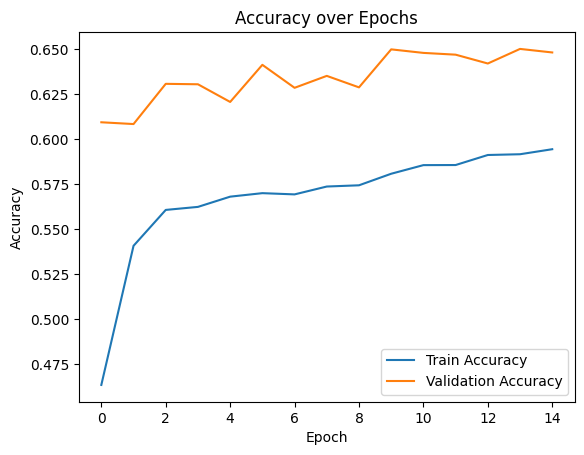

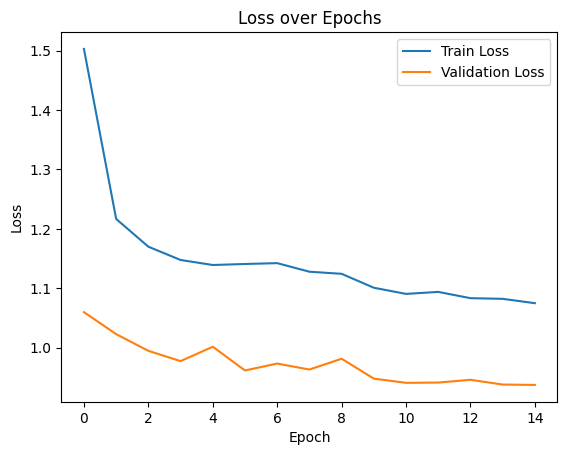

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


128/128 ━━━━━━━━━━━━━━━━━━━━ 32s 248ms/step - accuracy: 0.6784 - loss: 0.9134
Test Loss: 0.9087, Test Acc: 0.6776
128/128 ━━━━━━━━━━━━━━━━━━━━ 50s 306ms/step
                                                            precision    recall  f1-score   support

                                               Eczema 1677       0.40      0.20      0.27       188
                                               Melanoma 15       0.80      0.80      0.80       499
                                     Atopic Dermatitis - 1       0.56      0.49      0.52       312
                           Basal Cell Carcinoma (BCC) 3323       0.43      0.50      0.46       252
                              Melanocytic Nevi (NV) - 7970       0.82      0.90      0.86      1196
                  Benign Keratosis-like Lesions (BKL) 2624       0.89      0.76      0.82       471
Psoriasis pictures Lichen Planus and related diseases - 2k       0.47      0.36      0.41       308
          Seborrheic Keratoses and other 

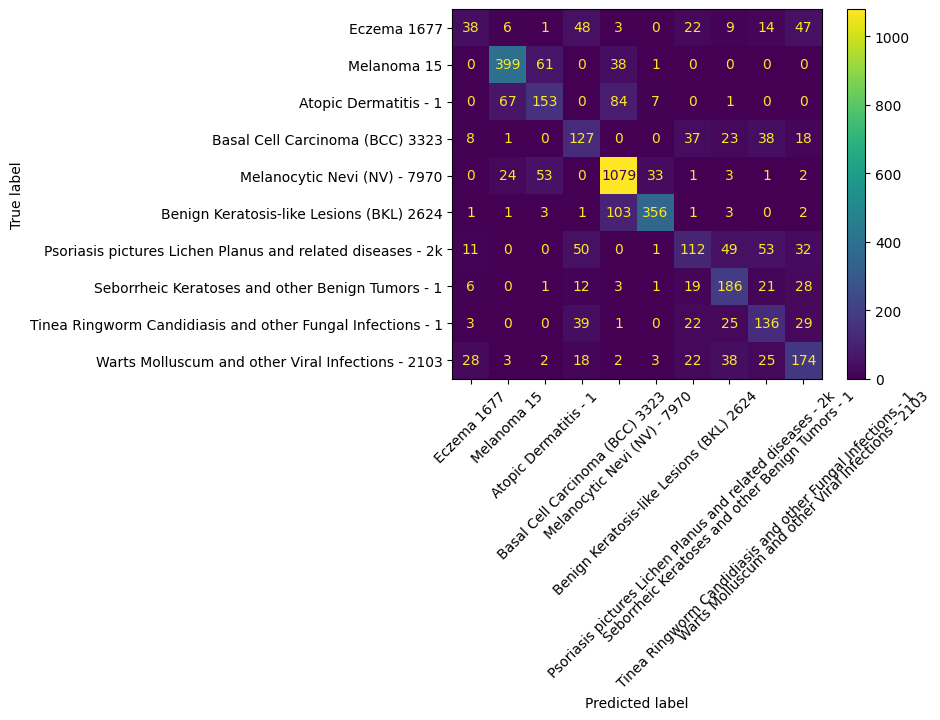

In [ ]:
# Use the best model
model.load_weights('/kaggle/working/best_model.h5')

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

# Classification Report
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_true, y_pred, target_names=[str(class_label_map[i]) for i in range(num_classes)]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=[str(class_label_map[i]) for i in range(num_classes)])
disp.plot(xticks_rotation=45)
plt.show()


In [ ]:
model.save('/kaggle/working/skin_disease_model.h5')


In [ ]:
import shutil
from tensorflow.keras.models import load_model

# 1. Save model in .h5 format
model.save("/kaggle/working/skin_disease_model.h5")

# 2. Zip the model file
shutil.make_archive("/kaggle/working/skin_disease_model", 'zip', "/kaggle/working", "skin_disease_model.h5")

# 3. Show download link
from IPython.display import FileLink
FileLink("/kaggle/working/skin_disease_model.zip")


/kaggle/working/skin_disease_model.zip